In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from hmmlearn.hmm import GaussianHMM
import statsmodels.api as sm
from regimeaware.routines import cfg
from datetime import datetime
from statsmodels.stats.weightstats import DescrStatsW
from itertools import permutations
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
from sklearn import preprocessing

NUM_STATES = 2
NUM_STOCKS = 1000
SIM_PERIODS = 600
MIN_OBS = 300
FCTRS = ["mktrf", "smb", "hml", "rmw", "cma", "umd"]
AS_OF_DT = datetime(2024, 12, 31)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["CMU Serif"]
})

dpi = 300
width = 7.5
height = 4.5

In [2]:
fctr_rt = pd.read_pickle(f"{cfg.fldr}/data/ff.pkl").loc[:AS_OF_DT, FCTRS]
crsp = pd.read_pickle(f"{cfg.fldr}/data/crsp.pkl")
sec_rt = crsp["excess_ret"]
mcap = crsp["mktcap"].xs(AS_OF_DT)

# Sample selection
obs_count = sec_rt.loc[:, pd.IndexSlice[mcap.index]].groupby("permno").count()
sample_ids = obs_count[obs_count >= MIN_OBS].index

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: 

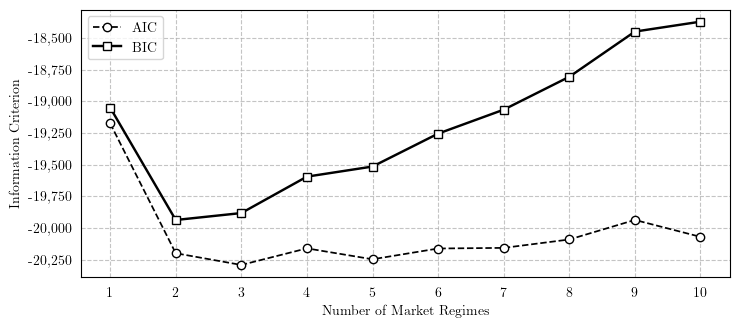

In [3]:
states_to_try = range(1, 11)

bic = pd.Series(index=states_to_try, dtype=float)
aic = pd.Series(index=states_to_try, dtype=float)
trn = fctr_rt.copy()

for n in states_to_try:
    mdl = GaussianHMM(
        n_components=n,
        covariance_type="full",
        random_state=cfg.hm_rs,
        implementation=cfg.hm_implementation
    )
    mdl.fit(trn)
    bic[n] = mdl.bic(trn)
    aic[n] = mdl.aic(trn)

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(width, height * .75), sharex=True, sharey=False)
plot_map = {'AIC': (aic, '--', 1.25, 'o'), 'BIC': (bic, '-', 1.75, 's')}

for label, params in plot_map.items():
    ax.plot(params[0], color='k', marker=params[3], mfc='white', lw=params[2], ls=params[1])
    ax.grid(ls='--', alpha=.75)

# ax.set_title('Information Criterion', weight='bold')
ax.set_ylabel('Information Criterion')
ax.set_xlabel('Number of Market Regimes')
ax.legend(['AIC', 'BIC'])
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.set_xticks(states_to_try)
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.tick_params(axis='both', bottom=False, left=False)
plt.tight_layout()
plt.savefig(f"{cfg.fldr}/img/state_calibration.pdf", dpi=dpi, transparent=True)
plt.show()


In [4]:
# Train HMM based on real data
mdl_hmm = GaussianHMM(
    n_components=NUM_STATES,
    covariance_type=cfg.hm_cov,
    random_state=cfg.hm_rs,
    min_covar=cfg.hm_min_covar,
    tol=cfg.hm_tol,
    implementation=cfg.hm_implementation
)

mdl_hmm.fit(fctr_rt)
smoothed_prob = pd.DataFrame(mdl_hmm.predict_proba(fctr_rt), index=fctr_rt.index, columns=range(NUM_STATES))
hmm_startprob = mdl_hmm.startprob_
hmm_transmat = mdl_hmm.transmat_
hmm_means = mdl_hmm.means_
hmm_covars = mdl_hmm.covars_

print(hmm_means * 12)

print(hmm_covars * 12)

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


[[ 0.11072406  0.02593846 -0.00205835  0.03693551  0.00032239  0.11590358]
 [-0.05522796  0.01663554  0.14200101  0.02576305  0.124485   -0.05791532]]
[[[0.01399793 0.         0.         0.         0.         0.        ]
  [0.         0.00685828 0.         0.         0.         0.        ]
  [0.         0.         0.00481652 0.         0.         0.        ]
  [0.         0.         0.         0.0025131  0.         0.        ]
  [0.         0.         0.         0.         0.00265951 0.        ]
  [0.         0.         0.         0.         0.         0.00749285]]

 [[0.05454706 0.         0.         0.         0.         0.        ]
  [0.         0.02565293 0.         0.         0.         0.        ]
  [0.         0.         0.02900528 0.         0.         0.        ]
  [0.         0.         0.         0.0175745  0.         0.        ]
  [0.         0.         0.         0.         0.01313926 0.        ]
  [0.         0.         0.         0.         0.         0.06219206]]]


In [5]:
# Collect regime-weighted parameters of our sample stocks
collect_params = {}
collect_scale = {}
for sec_id in sample_ids:
    y = sec_rt.xs(sec_id, level="permno").dropna()
    
    state_params = []
    for s in range(NUM_STATES):
        w = smoothed_prob.loc[y.index, s]
        mdl = sm.WLS(y, sm.add_constant(fctr_rt.loc[y.index, FCTRS]), weights=w).fit(disp=0)
        b = mdl.params.copy()
        b.index = pd.MultiIndex.from_product([b.index, [s]], names=["factor", "state"])
        state_params += [b]
        collect_scale[(sec_id, s)] = mdl.scale

    collect_params[sec_id] = pd.concat(state_params)

_midx = pd.MultiIndex.from_product([FCTRS, range(NUM_STATES)], names=["state", "factor"])
sample_params = pd.DataFrame.from_dict(collect_params, orient="index").loc[sample_ids, _midx]
scale_by_regime = pd.Series(collect_scale).groupby(level=1).mean()

In [6]:
# Loadings join-distribution (market-cap weighted)
wstats = DescrStatsW(sample_params, weights=mcap.reindex(sample_ids))

loadings_means = pd.Series(wstats.mean, index=_midx)

_temp_cov = pd.DataFrame(wstats.cov, index=_midx, columns=_midx)
loadings_cov = pd.DataFrame(0, index=_midx, columns=_midx)
for f in FCTRS:
    loadings_cov.loc[f, f] = _temp_cov.loc[f, f].values

In [7]:
print(loadings_means)

state  factor
mktrf  0         1.135901
       1         1.123395
smb    0         0.045818
       1         0.065408
hml    0        -0.212436
       1        -0.172706
rmw    0         0.009832
       1         0.058151
cma    0        -0.301690
       1        -0.050202
umd    0         0.051612
       1        -0.086778
dtype: float64


In [8]:
print(loadings_cov)

state            mktrf                 smb                 hml            \
factor               0         1         0         1         0         1   
state factor                                                               
mktrf 0       0.119079  0.079306  0.000000  0.000000  0.000000  0.000000   
      1       0.079306  0.096352  0.000000  0.000000  0.000000  0.000000   
smb   0       0.000000  0.000000  0.180234  0.142533  0.000000  0.000000   
      1       0.000000  0.000000  0.142533  0.184709  0.000000  0.000000   
hml   0       0.000000  0.000000  0.000000  0.000000  0.302147  0.252006   
      1       0.000000  0.000000  0.000000  0.000000  0.252006  0.348609   
rmw   0       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
      1       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
cma   0       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
      1       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
umd   0     

In [9]:
# Generate synthetic stock returns
gen_hmm = GaussianHMM(
    n_components=NUM_STATES,
    covariance_type=cfg.hm_cov,
    min_covar=cfg.hm_min_covar,
    tol=cfg.hm_tol,
    implementation=cfg.hm_implementation
)

# Seeds
gen_hmm.random_state = cfg.hm_rs
np.random.seed(cfg.hm_rs)

gen_hmm.startprob_ = hmm_startprob
gen_hmm.transmat_ = hmm_transmat
gen_hmm.means_ = hmm_means
gen_hmm.covars_ = np.array([np.diag(x) for x in hmm_covars])

X, Z = gen_hmm.sample(SIM_PERIODS)
G = gen_hmm.predict_proba(X)

# True factor loadings
_vals = np.random.multivariate_normal(mean=loadings_means, cov=loadings_cov, size=NUM_STOCKS)
B = pd.DataFrame(_vals, columns=loadings_means.index).T
B.columns.name = "stock"
B.index.names = ["factor", "state"]
B = B.stack()

# Stock returns
R = np.zeros((SIM_PERIODS, NUM_STOCKS))
for _t, s_t in enumerate(Z):
    x_t = pd.Series(X[_t], FCTRS)
    x_t.index.name = "factor"
    R[_t] += B.xs(s_t, level="state").mul(x_t).groupby("stock").sum()
    R[_t] += np.random.normal(loc=0, scale=scale_by_regime[s_t], size=NUM_STOCKS)  # Resids
    


In [10]:
hat_hmm = GaussianHMM(
    n_components=NUM_STATES,
    covariance_type="full",
    # covariance_type=cfg.hm_cov,
    min_covar=cfg.hm_min_covar,
    tol=cfg.hm_tol,
    random_state=cfg.hm_rs,
    implementation=cfg.hm_implementation
)
hat_hmm.fit(X)
G_hat = hat_hmm.predict_proba(X)

# Sort regime order for constitency
sort_res = {}
for x in permutations(range(NUM_STATES)):
    delta = G_hat[:, x] - G
    _, _S, _ = np.linalg.svd(delta)
    sort_res[x] = np.sum(_S)
state_srt = pd.Series(sort_res).idxmin()

G_hat = G_hat[:, state_srt]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
Model is not converging.  Current: 7970.249603492503 is not greater than 7970.367567417146. Delta is -0.11796392464293604


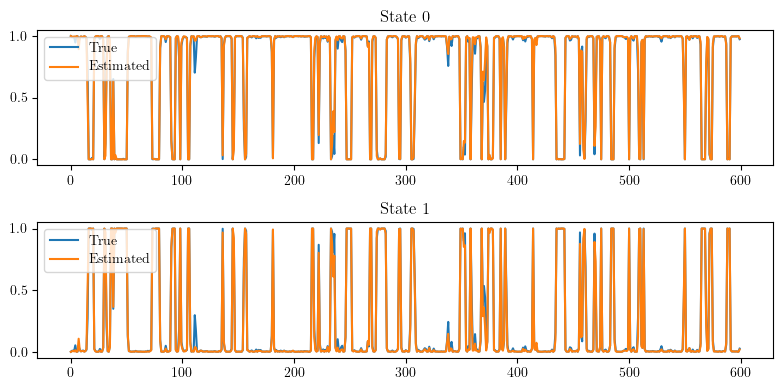

In [11]:
fig, axs = plt.subplots(figsize=(8, NUM_STATES * 2), nrows=NUM_STATES)
for s in range(NUM_STATES):
    axs[s].plot(G[:, s])
    axs[s].plot(G_hat[:, s])
    axs[s].set_title(f"State {s}")
    axs[s].legend(["True", "Estimated"], ncols=1, loc="upper left")

plt.tight_layout()

In [12]:
# Estimated parameters
collect_params_hat = {}
for i in range(NUM_STOCKS):
    y = R[:, i]
    
    state_params = []
    for s in range(NUM_STATES):
        w = G_hat[:, s]
        mdl = sm.WLS(y, X, weights=w).fit()
        _midx = pd.MultiIndex.from_product([FCTRS, [s]], names=["factor", "state"])
        b = pd.Series(mdl.params.copy(), index=_midx)
        state_params += [b]
        collect_scale[(i, s)] = mdl.scale

    collect_params_hat[i] = pd.concat(state_params)

B_hat = pd.DataFrame.from_dict(collect_params_hat).stack()
B_hat.index.names = ["factor", "state", "stock"]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\seaborn\axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


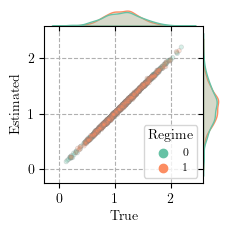

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\seaborn\axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


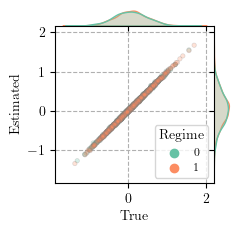

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\seaborn\axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


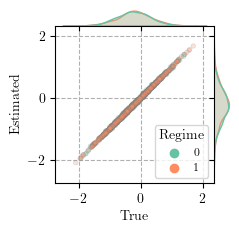

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\seaborn\axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


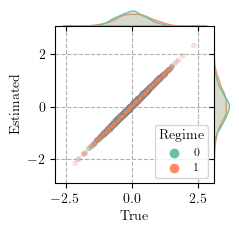

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\seaborn\axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


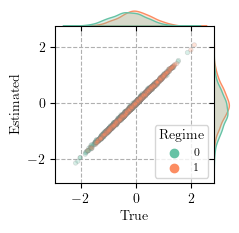

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\seaborn\axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


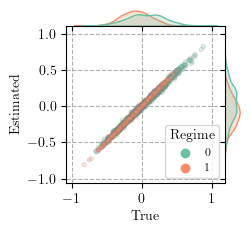

In [39]:
reco = pd.concat([B, B_hat], axis=1)
reco.columns = pd.Index(["True", "Estimated"], name="Loading")

for f in FCTRS:
    data = reco.xs(f, level="factor")
    g = sns.jointplot(data, x="True", y="Estimated", hue="state", space=0, palette="Set2", zorder=25, marginal_kws=dict(bw_adjust=1), height=2.25, ratio=10, alpha=.25, joint_kws={'edgecolor': 'gray', 'linewidth': .5, 's': 10})
    g.ax_joint.grid(ls='--', zorder=-25)
    g.ax_joint.legend(loc="lower right", fontsize=8, markerscale=1, title="Regime")
    g.ax_joint.set_xlabel(f"True")
    g.ax_joint.set_ylabel(f"Estimated")
    plt.savefig(f"{cfg.fldr}/img/recovery_{f}.pdf", dpi=50, transparent=False, bbox_inches='tight')
    plt.show()
    # g.fig.suptitle(f"Factor: {f}", y=1.02)